# **Data Preprocesssing**

In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [11]:
(train_ds, val_ds, test_ds), metadata = tfds.load('colorectal_histology', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], with_info=True, as_supervised=True, batch_size = 32)

In [12]:
num_classes = metadata.features['label'].num_classes
print(f"Number of Classes: {num_classes}")

Number of Classes: 8


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)

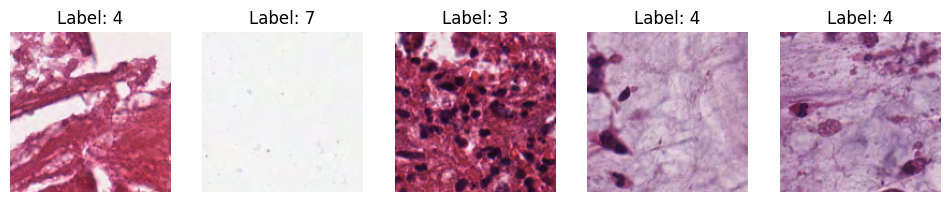

In [14]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_ds))

images = images[:5]
labels = labels[:5]

plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Label: {labels[i].numpy()}")
    plt.axis("off")

plt.show()

### **Resizing the images**

In [15]:
for x in train_ds.take(1):
    print(x[0].shape)

(32, 150, 150, 3)


In [16]:
def resize(image, label):
    image = tf.image.resize(image, [150, 150])
    image = tf.image.grayscale_to_rgb(image) if image.shape[-1] == 1 else image
    return tf.cast(image, tf.uint8), label

train_ds = train_ds.map(resize)

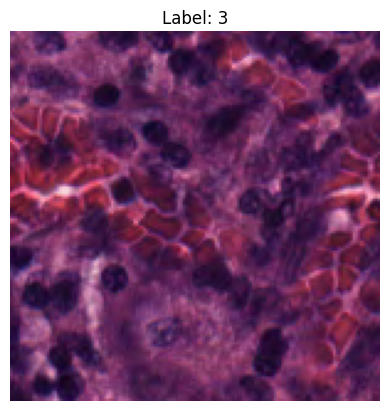

In [17]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    first_image = images[0].numpy()
    first_label = labels[0].numpy()
    break

plt.imshow(first_image.astype("uint8"))
plt.title(f"Label: {first_label}")
plt.axis('off')
plt.show()

### **Normalize Images**

In [18]:
def normalize_images(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds_2 = train_ds.map(normalize_images)
train_ds_1 = train_ds

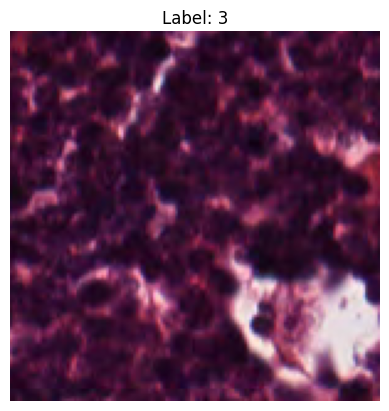

In [19]:
import matplotlib.pyplot as plt

for images, labels in train_ds_2.take(1):
    first_image = images[0].numpy()
    first_label = labels[0].numpy()
    break

plt.imshow(first_image)
plt.title(f"Label: {first_label}")
plt.axis('off')
plt.show()

### **Data Augmentation and Data Generation**

In [20]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)

    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image, label

for i in range(2):
    train_ds_2 = train_ds_2.concatenate(train_ds_2.map(augment))


In [21]:
total_images = 0
for image, label in train_ds_2.unbatch():
    total_images += 1

print(f"Total Images: {total_images}")

Total Images: 16000


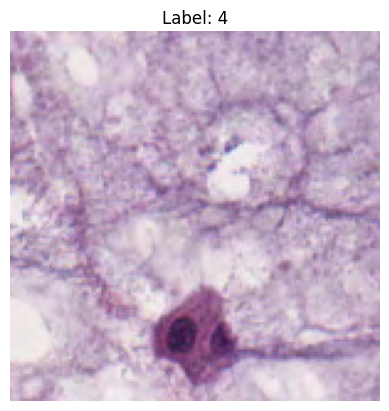

In [22]:
import matplotlib.pyplot as plt

for image, label in train_ds_2.take(1):
    image = image[0]
    label = label[0]
    plt.imshow(image.numpy()) 
    plt.title(f"Label: {str(label.numpy())}")          
    plt.axis("off")
    plt.show()


# **Calculating Region Of Interest**

In [23]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

from skimage.filters import gabor
from skimage.feature import graycomatrix, graycoprops
from skimage import measure, morphology
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler 

In [24]:
from skimage.filters import gabor
from skimage.feature import graycomatrix, graycoprops
from skimage import morphology
from skimage.measure import regionprops
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import cv2

def gabor_features(gray, mask, out_size=(150, 150)):
    # Resize gray and mask
    gray_resized = cv2.resize(gray, out_size, interpolation=cv2.INTER_AREA)
    mask_resized = cv2.resize(mask.astype(np.uint8), out_size, interpolation=cv2.INTER_NEAREST).astype(bool)

    feats = []
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    freqs = [0.1, 0.2, 0.3]

    for theta in thetas:
        for freq in freqs:
            filt_real, _ = gabor(gray_resized, frequency=freq, theta=theta)
            # Normalize to [0,1] to avoid huge values
            filt_real = (filt_real - filt_real.min()) / (filt_real.max() - filt_real.min() + 1e-6)
            feats.append(filt_real)

    gabor_stack = np.stack(feats, axis=-1)

    roi_vals = gabor_stack[mask_resized]   # ROI only

    if roi_vals.size == 0:   # edge case: empty mask
        return {"gabor_mean": 0.0, "gabor_std": 0.0}

    per_filter_mean = roi_vals.mean(axis=0)
    per_filter_std = roi_vals.std(axis=0)

    return {
        "gabor_mean": float(np.mean(per_filter_mean)),
        "gabor_std": float(np.mean(per_filter_std)),
    }


In [25]:
def extract_features(mask, gray, label):
    """Extract shape + intensity + GLCM features from ROI."""
    props = regionprops(mask.astype(int), intensity_image=gray)
    if not props:
        return None

    region = props[0]

    # Make sure gray and mask are aligned
    if gray.shape != mask.shape:
        raise ValueError(f"Gray shape {gray.shape} != Mask shape {mask.shape}")

    features = {
        "label": int(label.numpy()),
        "area": region.area,
        "perimeter": region.perimeter,
        "circularity": (4 * np.pi * region.area) / (region.perimeter ** 2 + 1e-6),
        "eccentricity": region.eccentricity,
        "solidity": region.solidity,
        "extent": region.extent,
        "mean_intensity": region.mean_intensity,
        "std_intensity": np.std(gray[mask.astype(bool)]),
        "skewness": skew(gray[mask.astype(bool)].ravel()),
        "kurtosis": kurtosis(gray[mask.astype(bool)].ravel())
    }

    # 🔹 GLCM texture features
    glcm = graycomatrix(gray, [1], [0], symmetric=True, normed=True)
    features.update({
        "contrast": graycoprops(glcm, 'contrast')[0, 0],
        "homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "energy": graycoprops(glcm, 'energy')[0, 0],
        "correlation": graycoprops(glcm, 'correlation')[0, 0],
    })

    return features

In [26]:
def process_image(image, label, k_clusters=3, out_size=(150, 150)):
    img = image.numpy().astype(np.uint8)

    # Ensure 3 channels
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    elif img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    # KMeans clustering on LAB
    H, W, _ = lab.shape
    features = lab.reshape(-1, 3).astype(np.float32)

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    km = KMeans(n_clusters=k_clusters, random_state=42, n_init=10)
    labels = km.fit_predict(features_scaled)
    segmented = labels.reshape(H, W)

    # ROI cluster = darkest average gray
    roi_cluster = np.argmin([np.mean(gray[segmented == i]) for i in range(k_clusters)])
    mask = (segmented == roi_cluster).astype(np.uint8)

    # Clean mask
    mask = morphology.remove_small_objects(mask.astype(bool), min_size=50)
    mask = mask.astype(np.uint8)

    # Force fixed size
    gray_resized = cv2.resize(gray, out_size, interpolation=cv2.INTER_AREA)
    mask_resized = cv2.resize(mask, out_size, interpolation=cv2.INTER_NEAREST).astype(bool)

    # Extract features
    feats = extract_features(mask_resized, gray_resized, label)
    if feats is None:
        return None

    # Add Gabor features
    gabor_stats = gabor_features(gray_resized, mask_resized)
    feats.update(gabor_stats)

    return feats

In [27]:
from tqdm import tqdm

def extract_from_dataset(dataset, k_clusters=3, limit=None):
    features = []
    
    # Try to get total for tqdm
    try:
        total = limit if limit is not None else len(dataset)
    except TypeError:
        total = None 
    
    for i, (image, label) in enumerate(tqdm(dataset, desc="Processing images", total=total)):
        if limit and i >= limit:
            break
        try:
            feats = process_image(image, label, k_clusters=k_clusters)
            if feats is not None:
                # Add image name in front (IMG_001, IMG_002, ...)
                feats_with_name = {"image_name": f"IMG_{i+1:03d}"}
                feats_with_name.update(feats)
                features.append(feats_with_name)
        except Exception as e:
            print(f"Error processing image {i}: {e}")
            
    return features


In [28]:
# train_features = extract_from_dataset(train_ds_1.unbatch(), k_clusters=3, limit=None) 
# df = pd.DataFrame(train_features)

In [29]:
# df.head(10)

In [30]:
# df.to_csv("colorectal_histology_features.csv", index=False)
# print("✅ Feature extraction complete. CSV saved.")

# **Building Model**

In [31]:
label_dict = {
    0: 'tumour epithelium',
    1: 'simple stroma',
    2: 'complex stroma',
    3: 'immune cell conglomerates',
    4: 'debris and mucus',
    5: 'mucosal glands',
    6: 'adipose tissue',
    7: 'background'
}

In [32]:
super_class_dict = {
    0: "tumour-related",
    1: "immune",
    2: "structural",
    3: "normal",
    4: "unknown"
}

In [33]:
def super_class(label):
    match label:
        case 0 | 1 | 2:
            category = 0
        case 3:
            category = 1
        case 4 | 7:
            category = 2
        case 5 | 6:
            category = 3
        case _:
            category = 4

    return category

In [34]:
import pandas as pd

df = pd.read_csv("/kaggle/input/colorectal-histology-ds/colorectal_histology_features_2.csv")
df.head()

,image_name,label,area,perimeter,circularity,eccentricity,solidity,extent,mean_intensity,std_intensity,skewness,kurtosis,contrast,homogeneity,energy,correlation,gabor_mean,gabor_std
0,IMG_002,4,7524.0,2091.398195,0.021616,0.579727,0.357877,0.334400,107.284955,30.907790,-0.700351,-0.566966,99.939329,0.159269,0.017766,0.973034,0.216771,0.368863
1,IMG_003,0,13607.0,2556.275395,0.026167,0.271925,0.619627,0.604756,53.994929,17.188968,0.481079,0.502652,131.479687,0.142530,0.018132,0.970037,0.205616,0.393809
2,IMG_004,6,1214.0,444.900541,0.077073,0.873132,0.094431,0.064747,135.331137,37.333076,-0.840162,-0.185551,103.207159,0.603985,0.194113,0.932612,0.309892,0.421601
3,IMG_005,2,6023.0,2100.171752,0.017160,0.479794,0.286974,0.267689,56.700315,17.505086,0.363996,0.011850,248.729664,0.105065,0.016178,0.873153,0.294104,0.430520
4,IMG_006,2,9589.0,3220.922148,0.011615,0.514338,0.436876,0.426178,66.131401,19.216715,0.272412,-0.149457,183.189306,0.112860,0.014813,0.929846,0.306662,0.449544


In [35]:
df["super_class"] = df["label"].apply(super_class)
df.head()

,image_name,label,area,perimeter,circularity,eccentricity,solidity,extent,mean_intensity,std_intensity,skewness,kurtosis,contrast,homogeneity,energy,correlation,gabor_mean,gabor_std,super_class
0,IMG_002,4,7524.0,2091.398195,0.021616,0.579727,0.357877,0.334400,107.284955,30.907790,-0.700351,-0.566966,99.939329,0.159269,0.017766,0.973034,0.216771,0.368863,2
1,IMG_003,0,13607.0,2556.275395,0.026167,0.271925,0.619627,0.604756,53.994929,17.188968,0.481079,0.502652,131.479687,0.142530,0.018132,0.970037,0.205616,0.393809,0
2,IMG_004,6,1214.0,444.900541,0.077073,0.873132,0.094431,0.064747,135.331137,37.333076,-0.840162,-0.185551,103.207159,0.603985,0.194113,0.932612,0.309892,0.421601,3
3,IMG_005,2,6023.0,2100.171752,0.017160,0.479794,0.286974,0.267689,56.700315,17.505086,0.363996,0.011850,248.729664,0.105065,0.016178,0.873153,0.294104,0.430520,0
4,IMG_006,2,9589.0,3220.922148,0.011615,0.514338,0.436876,0.426178,66.131401,19.216715,0.272412,-0.149457,183.189306,0.112860,0.014813,0.929846,0.306662,0.449544,0


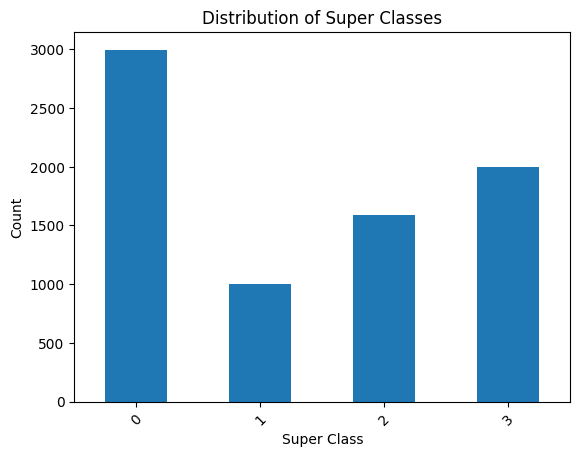

In [36]:
import matplotlib.pyplot as plt

df["super_class"].value_counts().sort_index().plot(kind="bar")
plt.xticks(rotation=45)
plt.title("Distribution of Super Classes")
plt.xlabel("Super Class")
plt.ylabel("Count")
plt.show()

In [37]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(df["super_class"])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=df["super_class"]
)

class_weights_dict = dict(zip(classes, class_weights))

## **Heirarchial Classification**

In [38]:
X = df.iloc[:, 2: -1]
y = df.iloc[:, -1]

classes = list(y.unique())

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler())

steps = list(pipe.steps)

### **Random Forest**

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


rf_steps = steps.copy()
rf_steps.append(("rf", RandomForestClassifier(n_jobs = -1, n_estimators = 1000, class_weight = class_weights_dict)))

rf_pipe = Pipeline(rf_steps)

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight={0: 0.6329219479653102,
                                                      1: 1.901302605210421,
                                                      2: 1.1911487758945387,
                                                      3: 0.9482758620689655},
                                        n_estimators=1000, n_jobs=-1))])

In [42]:
accuracy = rf_pipe.score(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 86.82%


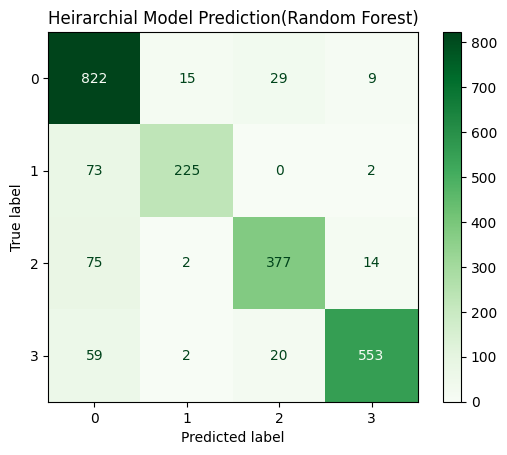

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_preds = rf_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap = "Greens")
plt.title("Heirarchial Model Prediction(Random Forest)")
plt.show()

### **LightGBM**

In [44]:
from lightgbm import LGBMClassifier

lgbm_steps = steps.copy()

lgbm_steps.append((
    "lgbm", 
    LGBMClassifier(
        objective='multiclass',
        num_class=len(classes),
        n_estimators=500,
        learning_rate=0.05,
        n_jobs=-1, class_weight = class_weights_dict
    )
))


lgbm_pipe = Pipeline(lgbm_steps)
lgbm_pipe.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5313, number of used features: 16
[LightGBM] [Info] Start training from score -1.373631
[LightGBM] [Info] Start training from score -1.386050
[LightGBM] [Info] Start training from score -1.376351
[LightGBM] [Info] Start training from score -1.409544


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbm',
                 LGBMClassifier(class_weight={0: 0.6329219479653102,
                                              1: 1.901302605210421,
                                              2: 1.1911487758945387,
                                              3: 0.9482758620689655},
                                learning_rate=0.05, n_estimators=500, n_jobs=-1,
                                num_class=4, objective='multiclass'))])

In [45]:
accuracy = lgbm_pipe.score(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 88.93%


### **CatBoost**

In [46]:
from catboost import CatBoostClassifier

cat_steps = steps.copy()

cat_steps.append((
    "catboost",
    CatBoostClassifier(
        iterations=1000,
        depth=10,
        learning_rate=0.05,
        loss_function='MultiClass',
        verbose=0,
        random_seed=42, class_weights = class_weights_dict
    )
))

cat_pipe = Pipeline(cat_steps)
cat_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x7c5688708510>)])

In [47]:
print(f"Accuracy: {cat_pipe.score(X_test, y_test) * 100 :.2f}%")

Accuracy: 87.92%


In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

def compare_models_metrics(models: dict, X_test, y_test, save_path=None):
    """
    Compare multiple classification models on test data and plot metrics.

    Args:
        models (dict): Dictionary of {model_name: trained_model}.
        X_test (array-like): Test features.
        y_test (array-like): True labels.
        save_path (str, optional): Path to save the figure. Defaults to None.

    Returns:
        None
    """
    metrics = ['F1-score', 'Recall', 'Precision', 'Accuracy', 'Error']
    n_metrics = len(metrics)

    # Prepare figure
    fig, axes = plt.subplots(1, n_metrics, figsize=(5*n_metrics, 5))
    
    # Compute metrics per model
    results = {metric: [] for metric in metrics}
    
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        
        results['F1-score'].append(f1_score(y_test, y_pred, average='macro'))
        results['Recall'].append(recall_score(y_test, y_pred, average='macro'))
        results['Precision'].append(precision_score(y_test, y_pred, average='macro'))
        acc = accuracy_score(y_test, y_pred)
        results['Accuracy'].append(acc)
        results['Error'].append(1 - acc)
    
    # Plot each metric
    for i, metric in enumerate(metrics):
        axes[i].bar(models.keys(), results[metric], color=['skyblue', 'salmon', 'lightgreen'])
        axes[i].set_title(metric)
        axes[i].set_ylim(0, 1)
        for j, val in enumerate(results[metric]):
            axes[i].text(j, val + 0.02, f"{val:.2f}", ha='center', fontsize=10)
        axes[i].set_xticklabels(models.keys(), rotation=45, ha='right')

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()


/tmp/ipykernel_38/3264200205.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(models.keys(), rotation=45, ha='right')


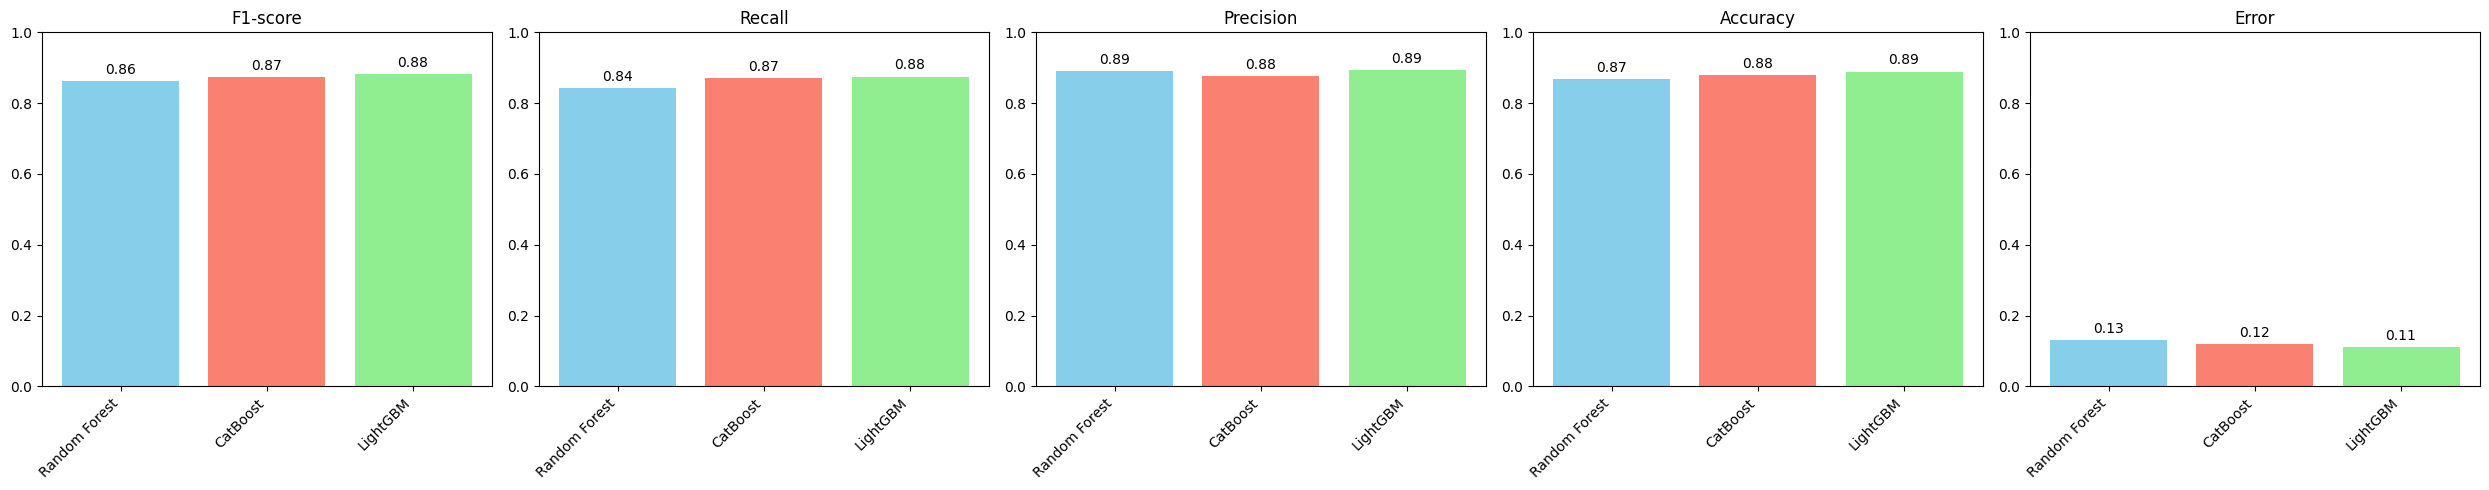

In [49]:
models = {"Random Forest":rf_pipe, "CatBoost":cat_pipe, "LightGBM":lgbm_pipe}

compare_models_metrics(models, X_test, y_test, "/kaggle/working/heirarchial.png")

In [50]:
import copy
first_model = copy.deepcopy(lgbm_pipe)

In [51]:
import joblib
joblib.dump(first_model, "heirarchial_model.pkl")

['heirarchial_model.pkl']

In [52]:
hierarchial_model = joblib.load("/kaggle/working/heirarchial_model.pkl")

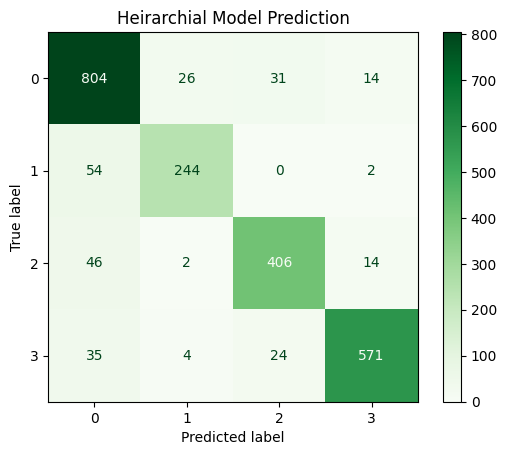

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_preds = hierarchial_model.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap = "Greens")
plt.title("Heirarchial Model Prediction")

plt.savefig("/kaggle/working/heirarchial_cm.png")
plt.show()

## **Building the Tumour Model**

In [54]:
df_tumour = df[df["super_class"] == 0]
df_tumour.head()

,image_name,label,area,perimeter,circularity,eccentricity,solidity,extent,mean_intensity,std_intensity,skewness,kurtosis,contrast,homogeneity,energy,correlation,gabor_mean,gabor_std,super_class
1,IMG_003,0,13607.0,2556.275395,0.026167,0.271925,0.619627,0.604756,53.994929,17.188968,0.481079,0.502652,131.479687,0.142530,0.018132,0.970037,0.205616,0.393809,0
3,IMG_005,2,6023.0,2100.171752,0.017160,0.479794,0.286974,0.267689,56.700315,17.505086,0.363996,0.011850,248.729664,0.105065,0.016178,0.873153,0.294104,0.430520,0
4,IMG_006,2,9589.0,3220.922148,0.011615,0.514338,0.436876,0.426178,66.131401,19.216715,0.272412,-0.149457,183.189306,0.112860,0.014813,0.929846,0.306662,0.449544,0
6,IMG_008,0,9408.0,4116.178028,0.006978,0.433302,0.429942,0.418133,47.517007,16.943174,0.955242,1.750037,153.033468,0.127965,0.018667,0.948057,0.293641,0.445527,0
7,IMG_009,1,12709.0,2468.789068,0.026203,0.426380,0.581355,0.564844,86.200645,19.775286,1.227606,2.238959,203.440089,0.155867,0.021492,0.969509,0.127511,0.307249,0


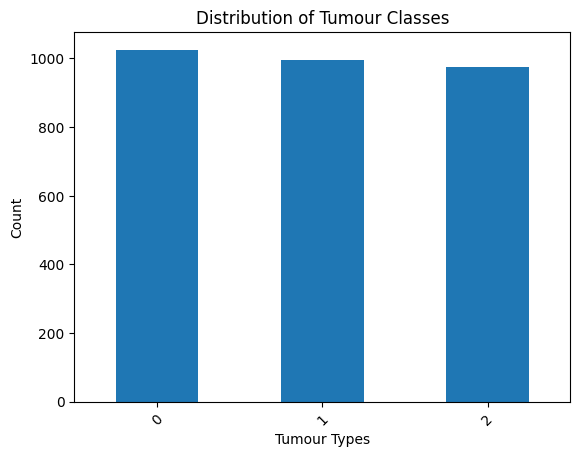

In [55]:
df_tumour["label"].value_counts().sort_index().plot(kind = "bar")
plt.xticks(rotation = 45)
plt.title("Distribution of Tumour Classes")
plt.ylabel("Count")
plt.xlabel("Tumour Types")
plt.show()

In [56]:
X, y = df_tumour.iloc[:, 2: -1], df_tumour.iloc[:, 1]
X.head()

,area,perimeter,circularity,eccentricity,solidity,extent,mean_intensity,std_intensity,skewness,kurtosis,contrast,homogeneity,energy,correlation,gabor_mean,gabor_std
1,13607.0,2556.275395,0.026167,0.271925,0.619627,0.604756,53.994929,17.188968,0.481079,0.502652,131.479687,0.142530,0.018132,0.970037,0.205616,0.393809
3,6023.0,2100.171752,0.017160,0.479794,0.286974,0.267689,56.700315,17.505086,0.363996,0.011850,248.729664,0.105065,0.016178,0.873153,0.294104,0.430520
4,9589.0,3220.922148,0.011615,0.514338,0.436876,0.426178,66.131401,19.216715,0.272412,-0.149457,183.189306,0.112860,0.014813,0.929846,0.306662,0.449544
6,9408.0,4116.178028,0.006978,0.433302,0.429942,0.418133,47.517007,16.943174,0.955242,1.750037,153.033468,0.127965,0.018667,0.948057,0.293641,0.445527
7,12709.0,2468.789068,0.026203,0.426380,0.581355,0.564844,86.200645,19.775286,1.227606,2.238959,203.440089,0.155867,0.021492,0.969509,0.127511,0.307249


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [58]:
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(0.95))
steps = list(pipe.steps)

### **Random Forest**

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_steps = steps.copy()

rf_steps.append(("rf", RandomForestClassifier(n_jobs = -1, n_estimators = 1000)))

rf_tumour_pipe = Pipeline(rf_steps)

rf_tumour_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('rf', RandomForestClassifier(n_estimators=1000, n_jobs=-1))])

In [60]:
accuracy = rf_tumour_pipe.score(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 86.00%


### **CatBoost**

In [61]:
from catboost import CatBoostClassifier

cat_steps = steps.copy()

cat_steps.append((
    "catboost",
    CatBoostClassifier(
        iterations=1000,
        depth=10,
        learning_rate=0.05,
        loss_function='MultiClass',
        verbose=0,
        random_seed=42
    )
))

cat_tumour_pipe = Pipeline(cat_steps)
cat_tumour_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x7c56abada690>)])

In [62]:
print(f"Accuracy: {cat_tumour_pipe.score(X_test, y_test) * 100 :.2f}%")

Accuracy: 85.56%


### **LightGBM**

In [63]:
from lightgbm import LGBMClassifier

lgbm_steps = steps.copy()

lgbm_steps.append((
    "lgbm", 
    LGBMClassifier(
        objective='multiclass',
        num_class=len(classes),
        n_estimators=500,
        learning_rate=0.05,
        n_jobs=-1
    )
))


lgbm_tumour_pipe = Pipeline(lgbm_steps)
lgbm_tumour_pipe.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 2098, number of used features: 9
[LightGBM] [Info] Start training from score -1.065331
[LightGBM] [Info] Start training from score -1.090542
[LightGBM] [Info] Start training from score -1.141462


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('lgbm',
                 LGBMClassifier(learning_rate=0.05, n_estimators=500, n_jobs=-1,
                                num_class=4, objective='multiclass'))])

In [64]:
accuracy = lgbm_tumour_pipe.score(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 84.33%


In [65]:
tumour_model = copy.deepcopy(cat_tumour_pipe)

In [66]:
joblib.dump(tumour_model, "tumour_model.pkl")

['tumour_model.pkl']

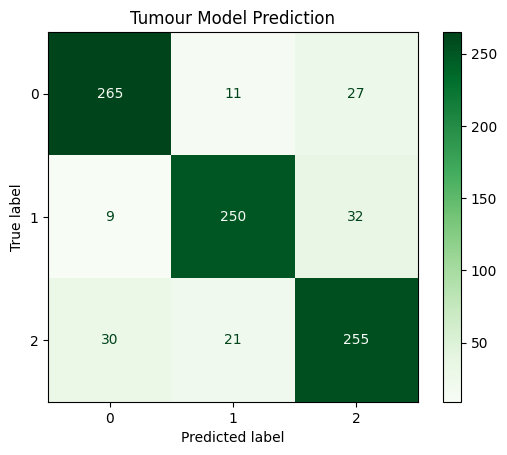

In [67]:
tumour_model = joblib.load("/kaggle/working/tumour_model.pkl")

y_preds = tumour_model.predict(X_test)
y_preds = y_preds.reshape(y_preds.shape[0])
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap = "Greens")
plt.title("Tumour Model Prediction")
plt.savefig("/kaggle/working/tumour_cm.png")
plt.show()

/tmp/ipykernel_38/3264200205.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(models.keys(), rotation=45, ha='right')


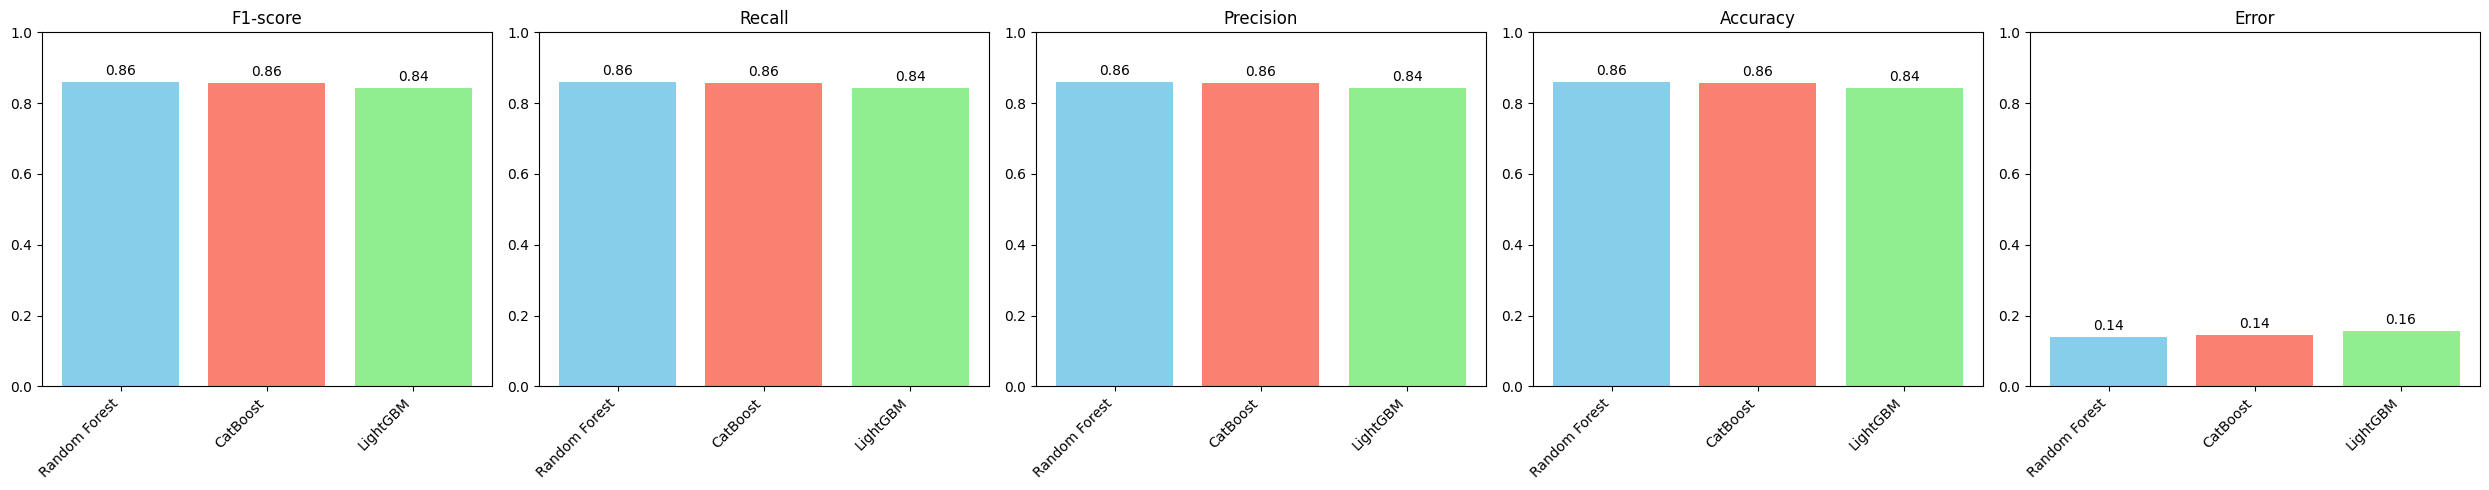

In [68]:
models = {"Random Forest":rf_tumour_pipe, "CatBoost":cat_tumour_pipe, "LightGBM":lgbm_tumour_pipe}

compare_models_metrics(models, X_test, y_test, "/kaggle/working/tumour.png")

## **Building the Structural Model**

In [69]:
df_structural = df[df["super_class"] == 2]
df_structural.head()

,image_name,label,area,perimeter,circularity,eccentricity,solidity,extent,mean_intensity,std_intensity,skewness,kurtosis,contrast,homogeneity,energy,correlation,gabor_mean,gabor_std,super_class
0,IMG_002,4,7524.0,2091.398195,0.021616,0.579727,0.357877,0.334400,107.284955,30.907790,-0.700351,-0.566966,99.939329,0.159269,0.017766,0.973034,0.216771,0.368863,2
16,IMG_018,7,186.0,68.941125,0.491775,0.911463,0.775000,0.466165,207.618280,13.525344,-1.023897,1.094860,4.462908,0.793790,0.365400,0.905376,0.273378,0.406570,2
27,IMG_030,7,7647.0,2148.170706,0.020824,0.489512,0.358240,0.339867,243.247679,1.022494,-2.391843,17.017144,0.233110,0.928581,0.496056,0.896619,0.000033,0.002306,2
30,IMG_033,7,1938.0,1056.257972,0.021828,0.929497,0.240835,0.201875,235.010320,2.890306,-4.442443,41.335771,1.979955,0.771286,0.296966,0.790155,0.003889,0.056579,2
39,IMG_043,4,8542.0,2866.323123,0.013065,0.561790,0.408845,0.379644,114.173027,26.557365,0.370919,-0.278166,160.947964,0.153580,0.015669,0.965377,0.199959,0.374883,2


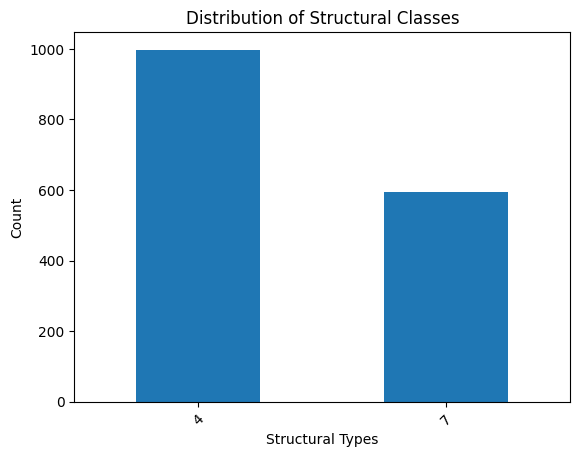

In [70]:
df_structural["label"].value_counts().sort_index().plot(kind = "bar")
plt.xticks(rotation = 45)
plt.title("Distribution of Structural Classes")
plt.ylabel("Count")
plt.xlabel("Structural Types")
plt.show()

In [71]:
X, y = df_structural.iloc[:, 2: -1], df_structural.iloc[:, 1]
X.head()

,area,perimeter,circularity,eccentricity,solidity,extent,mean_intensity,std_intensity,skewness,kurtosis,contrast,homogeneity,energy,correlation,gabor_mean,gabor_std
0,7524.0,2091.398195,0.021616,0.579727,0.357877,0.334400,107.284955,30.907790,-0.700351,-0.566966,99.939329,0.159269,0.017766,0.973034,0.216771,0.368863
16,186.0,68.941125,0.491775,0.911463,0.775000,0.466165,207.618280,13.525344,-1.023897,1.094860,4.462908,0.793790,0.365400,0.905376,0.273378,0.406570
27,7647.0,2148.170706,0.020824,0.489512,0.358240,0.339867,243.247679,1.022494,-2.391843,17.017144,0.233110,0.928581,0.496056,0.896619,0.000033,0.002306
30,1938.0,1056.257972,0.021828,0.929497,0.240835,0.201875,235.010320,2.890306,-4.442443,41.335771,1.979955,0.771286,0.296966,0.790155,0.003889,0.056579
39,8542.0,2866.323123,0.013065,0.561790,0.408845,0.379644,114.173027,26.557365,0.370919,-0.278166,160.947964,0.153580,0.015669,0.965377,0.199959,0.374883


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [73]:
from sklearn.utils.class_weight import compute_class_weight

classes_struc = np.unique(y_train)
class_weights_struc = compute_class_weight(
    class_weight='balanced',
    classes=classes_struc,
    y=y_train
)

class_weights_dict_struc = dict(zip(classes_struc, class_weights_struc))

In [74]:
pipe = make_pipeline(StandardScaler())
steps = list(pipe.steps)

### **Random Forest**

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_steps = steps.copy()

rf_steps.append(("rf", RandomForestClassifier(n_jobs = -1, n_estimators = 100, class_weight = class_weights_dict_struc)))

rf_structural_pipe = Pipeline(rf_steps)

rf_structural_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight={4: 0.7975679542203148,
                                                      7: 1.3401442307692308},
                                        n_jobs=-1))])

In [76]:
accuracy = rf_structural_pipe.score(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 99.79%


### **LightGBM**

In [77]:
from lightgbm import LGBMClassifier

lgbm_steps = steps.copy()

lgbm_steps.append((
    "lgbm", 
    LGBMClassifier(
        objective='multiclass',
        num_class=len(classes),
        n_estimators=500,
        learning_rate=0.05,
        n_jobs=-1, class_weight = class_weights_dict_struc
    )
))


lgbm_structural_pipe = Pipeline(lgbm_steps)
lgbm_structural_pipe.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1115, number of used features: 16
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbm',
                 LGBMClassifier(class_weight={4: 0.7975679542203148,
                                              7: 1.3401442307692308},
                                learning_rate=0.05, n_estimators=500, n_jobs=-1,
                                num_class=4, objective='multiclass'))])

In [78]:
accuracy = lgbm_structural_pipe.score(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 99.79%


### **CatBoost**

In [79]:
from catboost import CatBoostClassifier

cat_steps = steps.copy()

cat_steps.append((
    "catboost",
    CatBoostClassifier(
        iterations=1000,
        depth=10,
        learning_rate=0.05,
        loss_function='MultiClass',
        verbose=0,
        random_seed=42, class_weights = class_weights_dict_struc
    )
))

cat_structural_pipe = Pipeline(cat_steps)
cat_structural_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x7c56516ed410>)])

In [80]:
print(f"Accuracy: {cat_structural_pipe.score(X_test, y_test) * 100 :.2f}%")

Accuracy: 99.79%


In [81]:
joblib.dump( rf_structural_pipe, "structural_model.pkl")

['structural_model.pkl']

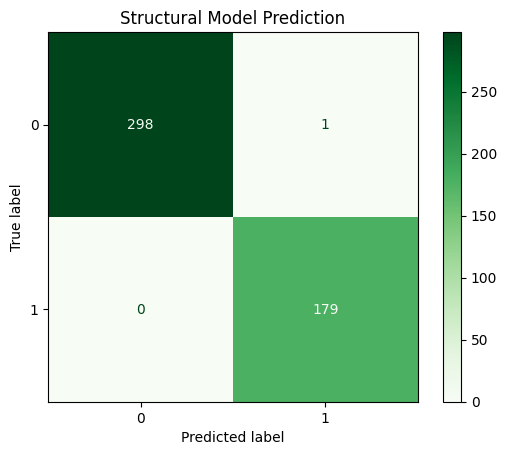

In [82]:
structural_model = joblib.load("/kaggle/working/structural_model.pkl")

y_preds = structural_model.predict(X_test)

cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap= "Greens")
plt.title("Structural Model Prediction")
plt.savefig("/kaggle/working/structural_cm.png")
plt.show()

/tmp/ipykernel_38/3264200205.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(models.keys(), rotation=45, ha='right')


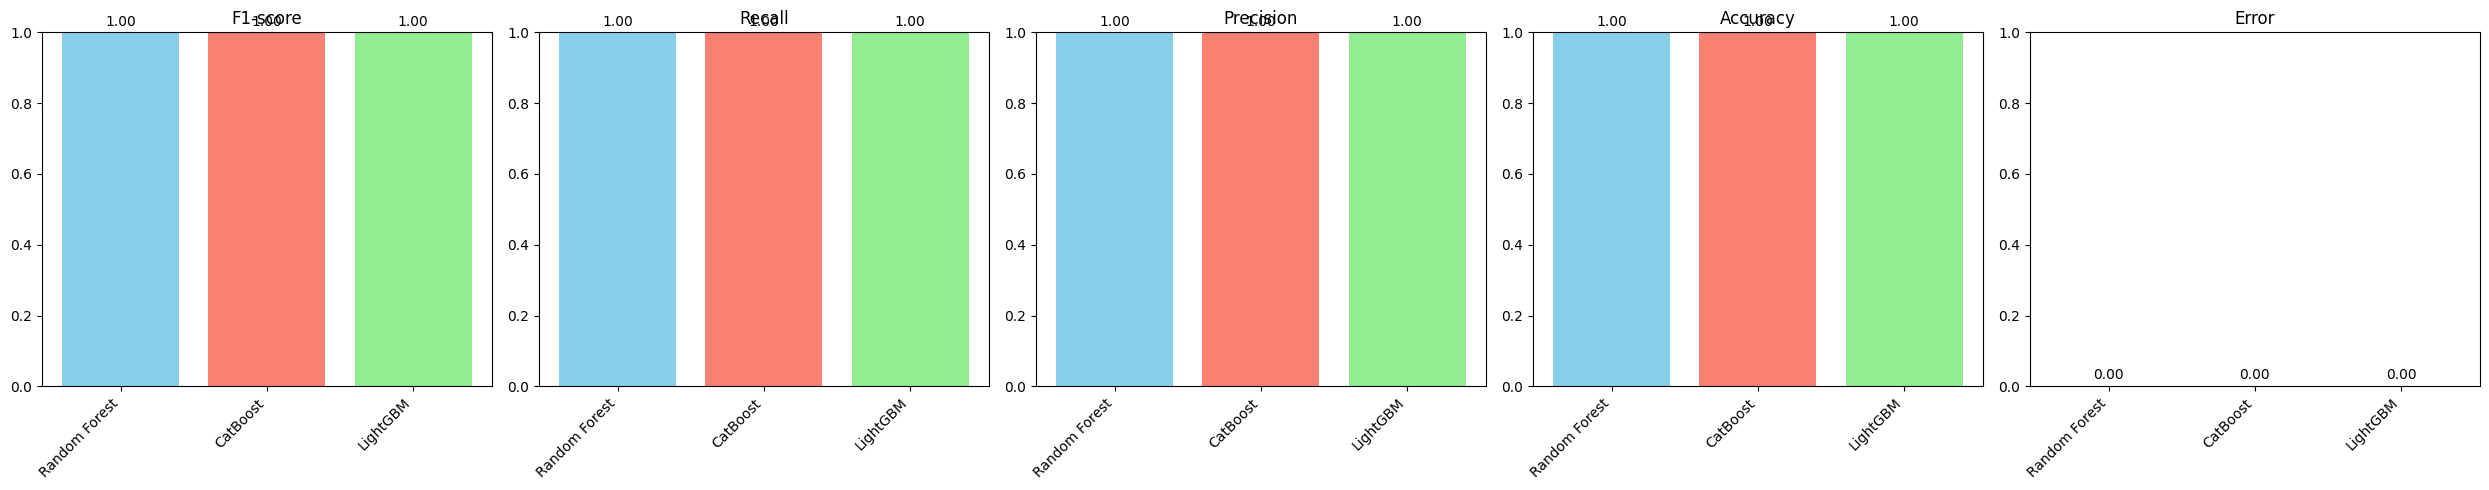

In [83]:
models = {"Random Forest":rf_structural_pipe, "CatBoost":cat_structural_pipe, "LightGBM":lgbm_structural_pipe}

compare_models_metrics(models, X_test, y_test, "/kaggle/working/structural.png")

## **Building Normal Model**

In [84]:
df_normal = df[df["super_class"] == 3]
df_normal.head()

,image_name,label,area,perimeter,circularity,eccentricity,solidity,extent,mean_intensity,std_intensity,skewness,kurtosis,contrast,homogeneity,energy,correlation,gabor_mean,gabor_std,super_class
2,IMG_004,6,1214.0,444.900541,0.077073,0.873132,0.094431,0.064747,135.331137,37.333076,-0.840162,-0.185551,103.207159,0.603985,0.194113,0.932612,0.309892,0.421601,3
5,IMG_007,6,1224.0,475.161472,0.068125,0.632125,0.130685,0.074862,151.044935,30.211300,-0.793320,0.544784,73.548233,0.588064,0.209643,0.936899,0.353956,0.458351,3
9,IMG_011,5,7481.0,2622.114970,0.013673,0.676853,0.342035,0.332489,72.749098,25.186310,0.362476,-0.527053,226.460403,0.104579,0.012068,0.957017,0.319093,0.450989,3
11,IMG_013,5,7695.0,2669.103823,0.013573,0.778182,0.415676,0.342000,53.022482,21.350472,1.170126,2.193725,245.708904,0.110412,0.012717,0.965876,0.291661,0.436434,3
17,IMG_019,5,7081.0,2624.453065,0.012919,0.348843,0.357103,0.314711,67.114108,25.191978,0.929875,0.863845,319.676331,0.118995,0.012466,0.958357,0.358177,0.448453,3


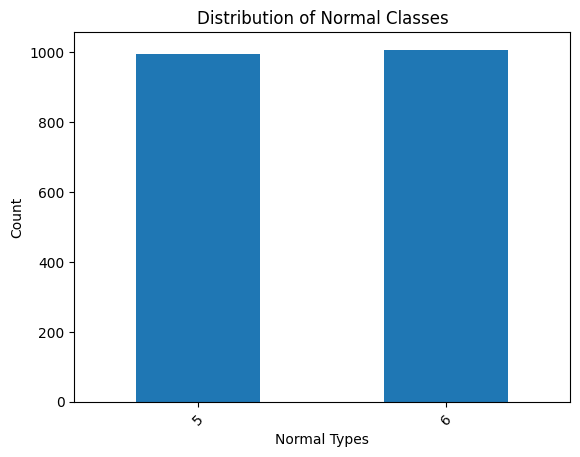

In [85]:
df_normal["label"].value_counts().sort_index().plot(kind = "bar")
plt.xticks(rotation = 45)
plt.title("Distribution of Normal Classes")
plt.ylabel("Count")
plt.xlabel("Normal Types")
plt.show()

In [86]:
X, y = df_normal.iloc[:, 2: -1], df_normal.iloc[:, 1]
X.head()

,area,perimeter,circularity,eccentricity,solidity,extent,mean_intensity,std_intensity,skewness,kurtosis,contrast,homogeneity,energy,correlation,gabor_mean,gabor_std
2,1214.0,444.900541,0.077073,0.873132,0.094431,0.064747,135.331137,37.333076,-0.840162,-0.185551,103.207159,0.603985,0.194113,0.932612,0.309892,0.421601
5,1224.0,475.161472,0.068125,0.632125,0.130685,0.074862,151.044935,30.211300,-0.793320,0.544784,73.548233,0.588064,0.209643,0.936899,0.353956,0.458351
9,7481.0,2622.114970,0.013673,0.676853,0.342035,0.332489,72.749098,25.186310,0.362476,-0.527053,226.460403,0.104579,0.012068,0.957017,0.319093,0.450989
11,7695.0,2669.103823,0.013573,0.778182,0.415676,0.342000,53.022482,21.350472,1.170126,2.193725,245.708904,0.110412,0.012717,0.965876,0.291661,0.436434
17,7081.0,2624.453065,0.012919,0.348843,0.357103,0.314711,67.114108,25.191978,0.929875,0.863845,319.676331,0.118995,0.012466,0.958357,0.358177,0.448453


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [88]:
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(),PCA(0.95))
steps = list(pipe.steps)

### **Random Forest**

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_normal_steps = steps.copy()

rf_normal_steps.append(("rf", RandomForestClassifier(n_jobs = -1, n_estimators = 1000)))

rf_normal_pipe = Pipeline(rf_normal_steps)

rf_normal_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('rf', RandomForestClassifier(n_estimators=1000, n_jobs=-1))])

In [90]:
accuracy = rf_normal_pipe.score(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 99.83%


### **LightGBM**

In [91]:
from lightgbm import LGBMClassifier

lgbm_steps = steps.copy()

lgbm_steps.append((
    "lgbm", 
    LGBMClassifier(
        objective='multiclass',
        num_class=len(classes),
        n_estimators=500,
        learning_rate=0.05,
        n_jobs=-1
    )
))


lgbm_normal_pipe = Pipeline(lgbm_steps)
lgbm_normal_pipe.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 9
[LightGBM] [Info] Start training from score -0.688871
[LightGBM] [Info] Start training from score -0.697442
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('lgbm',
                 LGBMClassifier(learning_rate=0.05, n_estimators=500, n_jobs=-1,
                                num_class=4, objective='multiclass'))])

In [92]:
accuracy = lgbm_normal_pipe.score(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 99.50%


### **CatBoost**

In [93]:
from catboost import CatBoostClassifier

cat_steps = steps.copy()

cat_steps.append((
    "catboost",
    CatBoostClassifier(
        iterations=1000,
        depth=10,
        learning_rate=0.05,
        loss_function='MultiClass',
        verbose=0,
        random_seed=42
    )
))

cat_normal_pipe = Pipeline(cat_steps)
cat_normal_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x7c56cc56e390>)])

In [94]:
print(f"Accuracy: {cat_normal_pipe.score(X_test, y_test) * 100 :.2f}%")

Accuracy: 99.83%


In [95]:
joblib.dump(rf_normal_pipe, "normal_model.pkl")

['normal_model.pkl']

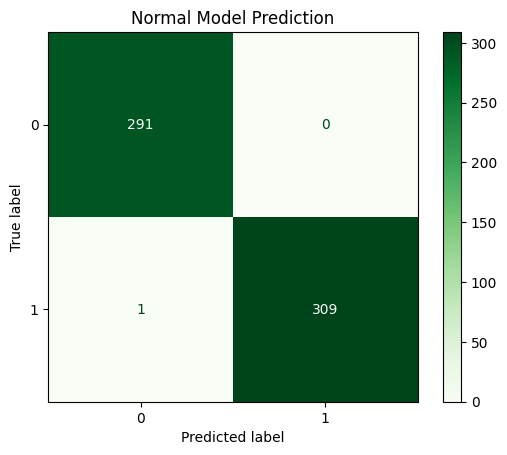

In [96]:
normal_model = joblib.load("/kaggle/working/normal_model.pkl")

y_preds = normal_model.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap = "Greens")
plt.title("Normal Model Prediction")
plt.savefig("/kaggle/working/normal_cm.png")
plt.show()

/tmp/ipykernel_38/3264200205.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(models.keys(), rotation=45, ha='right')


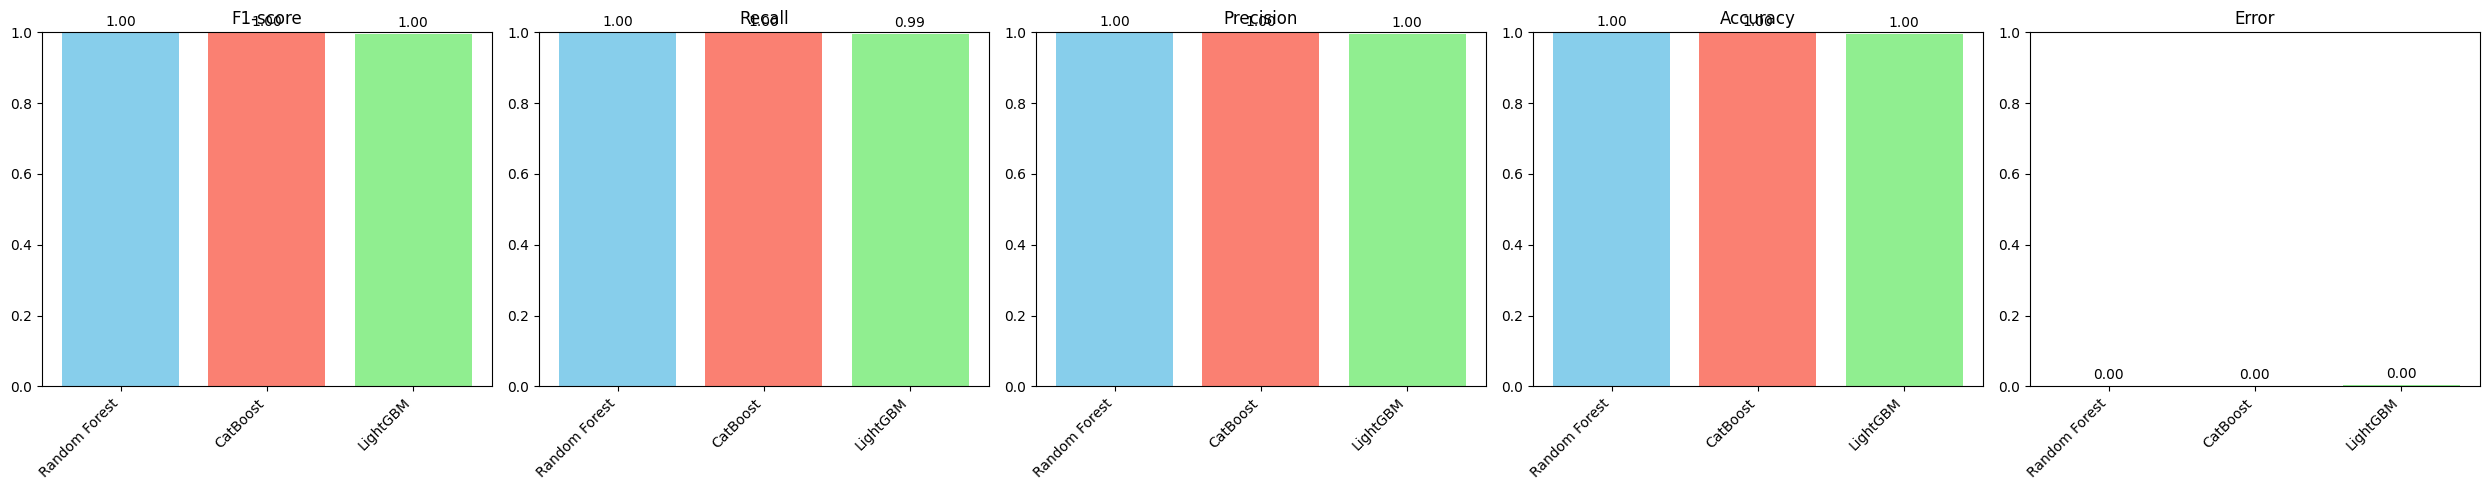

In [97]:
models = {"Random Forest":rf_normal_pipe, "CatBoost":cat_normal_pipe, "LightGBM":lgbm_normal_pipe}

compare_models_metrics(models, X_test, y_test, "/kaggle/working/normal.png")

In [98]:
!zip -r /kaggle/working/output.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/heirarchial_cm.png (deflated 12%)
  adding: kaggle/working/structural.png (deflated 43%)
  adding: kaggle/working/tumour_cm.png (deflated 12%)
  adding: kaggle/working/tumour.png (deflated 39%)
  adding: kaggle/working/heirarchial.png (deflated 38%)
  adding: kaggle/working/normal_model.pkl (deflated 81%)
  adding: kaggle/working/structural_cm.png (deflated 14%)
  adding: kaggle/working/normal_cm.png (deflated 14%)
  adding: kaggle/working/normal.png (deflated 41%)
  adding: kaggle/working/catboost_info/ (stored 0%)
  adding: kaggle/working/catboost_info/learn_error.tsv (deflated 57%)
  adding: kaggle/working/catboost_info/tmp/ (stored 0%)
  adding: kaggle/working/catboost_info/catboost_training.json (deflated 76%)
  adding: kaggle/working/catboost_info/time_left.tsv (deflated 51%)
  adding: kaggle/working/catboost_info/learn/ (stored 0%)
  adding: kaggle/working/catboost_info/learn/events.out.tfevents (deflated 78%)
  addi

In [104]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 11.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.37.2
    Uninstalling pydantic_core-2.37.2:
      Successfully uninstalled pydantic_core-2.37.2
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.12.0a1
    Uninstalling pydantic-2.12.0a1:
      Successfully uninstalled pydantic-2.12.0a1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [105]:
# ===========================
# 📦 Imports
# ===========================
import gradio as gr
import pickle
import numpy as np
from PIL import Image
from torchvision import transforms
import joblib
import pandas as pd

# ===========================
# ⚙️ Load Models
# ===========================
# Update paths according to your Kaggle input directory
MODEL_PATH = "/kaggle/input/your-models"

hybrid_model = joblib.load("/kaggle/input/colorectal-histology-model/scikitlearn/default/1/kaggle/working/heirarchial_model.pkl")

tumour_model = joblib.load("/kaggle/input/colorectal-histology-model/scikitlearn/default/1/kaggle/working/tumour_model.pkl")

structural_model = joblib.load("/kaggle/input/colorectal-histology-model/scikitlearn/default/1/kaggle/working/structural_model.pkl")

normal_model = joblib.load("/kaggle/input/colorectal-histology-model/scikitlearn/default/1/kaggle/working/normal_model.pkl")

# ===========================
# 🧠 Dictionaries
# ===========================
super_class_dict = {
    0: "tumour-related",
    1: "immune",
    2: "structural",
    3: "normal",
    4: "unknown"
}

label_dict = {
    0: 'tumour epithelium',
    1: 'simple stroma',
    2: 'complex stroma',
    3: 'immune cell conglomerates',
    4: 'debris and mucus',
    5: 'mucosal glands',
    6: 'adipose tissue',
    7: 'background'
}

def super_class(label):
    match label:
        case 0 | 1 | 2:
            category = 0
        case 3:
            category = 1
        case 4 | 7:
            category = 2
        case 5 | 6:
            category = 3
        case _:
            category = 4
    return category

# ===========================
# 🧩 Feature Extraction
# ===========================
import numpy as np
import cv2
from skimage.filters import gabor
from skimage.feature import graycomatrix, graycoprops
from skimage import morphology
from skimage.measure import regionprops
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def extract_features_single(image_pil, k_clusters=3, out_size=(150, 150)):
    """
    Extract the same handcrafted features for a single user-uploaded PIL image.
    Returns a numpy feature vector (1, N) ready for model prediction.
    """
    # Convert PIL to numpy
    img = np.array(image_pil)

    # Ensure correct channel order
    if img.ndim == 2:  # grayscale
        img = np.stack([img]*3, axis=-1)
    elif img.shape[-1] == 4:  # RGBA → RGB
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    # KMeans segmentation (same as training)
    H, W, _ = lab.shape
    features = lab.reshape(-1, 3).astype(np.float32)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    km = KMeans(n_clusters=k_clusters, random_state=42, n_init=10)
    labels = km.fit_predict(features_scaled)
    segmented = labels.reshape(H, W)

    # Select ROI = darkest average gray region
    roi_cluster = np.argmin([np.mean(gray[segmented == i]) for i in range(k_clusters)])
    mask = (segmented == roi_cluster).astype(np.uint8)
    mask = morphology.remove_small_objects(mask.astype(bool), min_size=50)
    mask = mask.astype(np.uint8)

    # Resize for consistency
    gray_resized = cv2.resize(gray, out_size, interpolation=cv2.INTER_AREA)
    mask_resized = cv2.resize(mask, out_size, interpolation=cv2.INTER_NEAREST).astype(bool)

    # ---- Region features ----
    props = regionprops(mask_resized.astype(int), intensity_image=gray_resized)
    if not props:
        raise ValueError("No region found in mask.")
    region = props[0]

    features_dict = {
        "area": region.area,
        "perimeter": region.perimeter,
        "circularity": (4 * np.pi * region.area) / (region.perimeter ** 2 + 1e-6),
        "eccentricity": region.eccentricity,
        "solidity": region.solidity,
        "extent": region.extent,
        "mean_intensity": region.mean_intensity,
        "std_intensity": np.std(gray_resized[mask_resized]),
        "skewness": skew(gray_resized[mask_resized].ravel()),
        "kurtosis": kurtosis(gray_resized[mask_resized].ravel())
    }

    # ---- Texture features (GLCM) ----
    glcm = graycomatrix(gray_resized, [1], [0], symmetric=True, normed=True)
    features_dict.update({
        "contrast": graycoprops(glcm, 'contrast')[0, 0],
        "homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "energy": graycoprops(glcm, 'energy')[0, 0],
        "correlation": graycoprops(glcm, 'correlation')[0, 0],
    })

    # ---- Gabor features ----
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    freqs = [0.1, 0.2, 0.3]
    feats = []
    for theta in thetas:
        for freq in freqs:
            filt_real, _ = gabor(gray_resized, frequency=freq, theta=theta)
            filt_real = (filt_real - filt_real.min()) / (filt_real.max() - filt_real.min() + 1e-6)
            feats.append(filt_real)
    gabor_stack = np.stack(feats, axis=-1)
    roi_vals = gabor_stack[mask_resized]
    per_filter_mean = roi_vals.mean(axis=0)
    per_filter_std = roi_vals.std(axis=0)
    features_dict.update({
        "gabor_mean": float(np.mean(per_filter_mean)),
        "gabor_std": float(np.mean(per_filter_std))
    })

    # ---- Convert to vector (1 x N) ----
    feature_vector = np.array(list(features_dict.values()), dtype=np.float32).reshape(1, -1)
    return feature_vector



# ===========================
# 🚀 Prediction Logic
# ===========================
def predict(image):
    # Extract features
    try:
        image_features =  extract_features_single(image)
    except:
        return "unknown", "unknown"
    features=pd.DataFrame(image_features)
    # Predict superclass
    super_pred = hybrid_model.predict(features)[0]
    superclass_name = super_class_dict.get(super_pred, "unknown")
    print(superclass_name)

    # Based on superclass, pick correct model
    if super_pred == 0:  # tumour-related
        sub_pred = tumour_model.predict(features)[0][0]
        print(sub_pred)
        label_name = label_dict.get(sub_pred,"unknown")

    elif super_pred == 1:  # immune
        label_name = "immune cell conglomerates"

    elif super_pred == 2:  # structural
        sub_pred = structural_model.predict(features)[0]
        label_name = label_dict.get(sub_pred,"unknown")

    elif super_pred == 3:  # normal
        sub_pred = normal_model.predict(features)[0]
        label_name = label_dict.get(sub_pred,"unknown")

    else:  # unknown
        label_name = "unknown"

    return superclass_name, label_name

# ===========================
# 🎨 Gradio UI
# ===========================
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload Histopathology Image"),
    outputs=[
        gr.Label(label="Superclass Prediction"),
        gr.Label(label="Detailed Label Prediction")
    ],
    title="🧬 Hybrid Image Classifier",
    description=(
        "Uploads an image → Extracts features → Predicts superclass (0–4) "
        "and then uses the corresponding submodel for fine-grained classification."
    )
)

# ===========================
# ▶️ Launch
# ===========================
demo.launch()

* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://ad9a7d7d92971e6780.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [106]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

os.makedirs("saved_test_images", exist_ok=True)

# Iterate over dataset
for i, (image, label) in enumerate(test_ds.unbatch().take(30)): 
    img = tf.image.convert_image_dtype(image, dtype=tf.uint8).numpy()
    
    plt.imsave(f"saved_test_images/test_img_{i+1}.png", img)
    
    print(f"Saved test_img_{i+1}.png (label: {label.numpy()})")

print("✅ Done saving sample images!")

Saved test_img_1.png (label: 1)
Saved test_img_2.png (label: 0)
Saved test_img_3.png (label: 5)
Saved test_img_4.png (label: 3)
Saved test_img_5.png (label: 5)
Saved test_img_6.png (label: 3)
Saved test_img_7.png (label: 5)
Saved test_img_8.png (label: 0)
Saved test_img_9.png (label: 6)
Saved test_img_10.png (label: 5)
Saved test_img_11.png (label: 6)
Saved test_img_12.png (label: 2)
Saved test_img_13.png (label: 6)
Saved test_img_14.png (label: 2)
Saved test_img_15.png (label: 4)
Saved test_img_16.png (label: 7)
Saved test_img_17.png (label: 5)
Saved test_img_18.png (label: 4)
Saved test_img_19.png (label: 5)
Saved test_img_20.png (label: 7)
Saved test_img_21.png (label: 4)
Saved test_img_22.png (label: 4)
Saved test_img_23.png (label: 6)
Saved test_img_24.png (label: 6)
Saved test_img_25.png (label: 2)
Saved test_img_26.png (label: 0)
Saved test_img_27.png (label: 0)
Saved test_img_28.png (label: 2)
Saved test_img_29.png (label: 6)
Saved test_img_30.png (label: 5)
✅ Done saving sampl

In [108]:
!zip -r /kaggle/working/sample_images.zip /kaggle/working/saved_test_images/

updating: kaggle/working/saved_test_images/ (stored 0%)
updating: kaggle/working/saved_test_images/test_img_27.png (deflated 0%)
updating: kaggle/working/saved_test_images/test_img_17.png (deflated 0%)
updating: kaggle/working/saved_test_images/test_img_22.png (deflated 0%)
updating: kaggle/working/saved_test_images/test_img_7.png (deflated 0%)
updating: kaggle/working/saved_test_images/test_img_19.png (deflated 0%)
updating: kaggle/working/saved_test_images/test_img_23.png (stored 0%)
updating: kaggle/working/saved_test_images/test_img_3.png (deflated 0%)
updating: kaggle/working/saved_test_images/test_img_12.png (deflated 0%)
updating: kaggle/working/saved_test_images/test_img_29.png (stored 0%)
updating: kaggle/working/saved_test_images/test_img_30.png (deflated 0%)
updating: kaggle/working/saved_test_images/test_img_18.png (deflated 0%)
updating: kaggle/working/saved_test_images/test_img_28.png (deflated 0%)
updating: kaggle/working/saved_test_images/test_img_21.png (deflated 0%)
u

In [109]:
!pip freeze > requirements.txt